In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from datasets import Dataset
from IPython.display import display
import numpy as np 
import os
import pandas as pd
from pathlib import Path
from pydub import AudioSegment
import torch
from transformers import Wav2Vec2ForSequenceClassification, Wav2Vec2FeatureExtractor


import warnings
warnings.filterwarnings('ignore')

## Set seed
SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)


from ferret.benchmark_speech import SpeechBenchmark

In [3]:
dataset_name = 'FSC'
data_dir = f'{str(Path.home())}/data/speech/fluent_speech_commands_dataset'

# We read the test data of FSC dataset
df = pd.read_csv(f"{data_dir}/data/test_data.csv")
df["path"] = df["path"].apply(lambda x: os.path.join(data_dir, x))

dataset = Dataset.from_pandas(df)

In [4]:
device_str = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device = torch.device(device_str)

In [5]:
## Load model
model = Wav2Vec2ForSequenceClassification.from_pretrained(
    "superb/wav2vec2-base-superb-ic"
)
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(
    "superb/wav2vec2-base-superb-ic"
)

if torch.cuda.is_available():
    model = model.to(device)

In [6]:
## Instantiate benchmark class
benchmark = Benchmark(model, feature_extractor, device=device_str)

In [7]:
## Example
# 'transcription': 'Turn up the bedroom heat.'
# 'action': 'increase'
# 'object': 'heat'
# 'location': 'bedroom'

idx = 136
audio_path = dataset[idx]['path']

In [8]:
audio = AudioSegment.from_wav(audio_path)
display(audio)

In [9]:
transcriptions_file = f'./transcriptions_{dataset_name}.pickle'

import pickle
# Load the transcriptions, if available
if os.path.exists(transcriptions_file):
    with open(transcriptions_file, "rb") as handle:
        transcriptions = pickle.load(handle)
else:
    transcriptions = {}

In [10]:
word_transcript = transcriptions[idx] if transcriptions else None

# Explain word importance

In [11]:
explanation = benchmark.explain(
    audio_path=audio_path, 
    methodology='LOO', words_trascript=word_transcript)

In [12]:
display(benchmark.show_table(explanation, decimals=3))

,Turn,up,the,bedroom,heat.
action=increase,0.250,0.545,0.260,0.139,0.021
object=heat,-0.000,-0.000,-0.000,0.014,0.550
location=bedroom,0.002,0.006,0.087,0.997,0.323


In [13]:
explanation = benchmark.explain(
    audio_path=audio_path, 
    methodology='LIME', words_trascript=word_transcript)
display(benchmark.show_table(explanation, decimals=3))

,Turn,up,the,bedroom,heat.
action=increase,0.149,0.311,0.073,0.301,0.117
object=heat,0.017,-0.002,0.066,0.024,0.230
location=bedroom,-0.095,0.010,0.291,0.714,0.043


In [14]:
from speechxai import AOPC_Comprehensiveness_Evaluation_Speech, AOPC_Sufficiency_Evaluation_Speech

aopc_compr = AOPC_Comprehensiveness_Evaluation_Speech(benchmark.model_helper)
evaluation_output_c = aopc_compr.compute_evaluation(explanation, words_trascript=word_transcript)

aopc_suff = AOPC_Sufficiency_Evaluation_Speech(benchmark.model_helper)
evaluation_output_s = aopc_suff.compute_evaluation(explanation, words_trascript=word_transcript)

evaluation_output_c

EvaluationSpeech(name='aopc_compr', score=[0.8899634336703457, 0.49365800246596336, 0.9775487923980108], target=[3, 4, 2])

# Explain paralinguistic impact

In [15]:
explain_table = benchmark.explain(
        audio_path=audio_path,
        methodology='perturb_paraling',
        )
display(benchmark.show_table(explain_table, decimals=2))

,pitch shifting,pitch shifting down,pitch shifting up,time stretching,time stretching down,time stretching up,reverberation,noise
action=increase,0.08,0.04,0.13,0.11,0.19,0.04,0.77,0.44
object=heat,0.02,-0.00,0.04,0.00,0.00,0.00,0.00,0.29
location=bedroom,0.22,0.13,0.33,0.02,0.03,0.01,0.36,0.60


# Show variation

In [16]:
perturbation_types = ['time stretching', 'pitch shifting', 'reverberation', 'noise']
variations_table = benchmark.explain_variations(
        audio_path=audio_path,
        perturbation_types=perturbation_types)

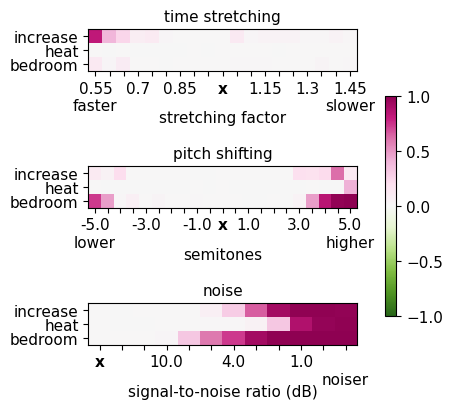

In [17]:
variations_table_plot = {k:variations_table[k] for k in variations_table if k in ['time stretching', 'pitch shifting', 'noise']}
fig = benchmark.plot_variations(variations_table_plot, show_diff = True, figsize=(4.6, 4.2));
fig.savefig(f'example_{dataset_name}_context.pdf', bbox_inches='tight')